In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
len(os.listdir('/content/drive/My Drive/CartoonGAN/train_X/'))

2

In [3]:
import os
import cv2
import numpy as np
import glob
import pandas as pd
import tensorflow as tf
import time
from easydict import EasyDict as edict
from tensorflow.contrib.data import prefetch_to_device, shuffle_and_repeat, map_and_batch
import skimage.io as io

In [0]:
config                       = edict()

config.BATCH_SIZE            = 1
config.NUM_RESNET_BLOCKS     = 8
config.NUM_DOWN_CONV_BLOCKS  = 2
config.NUM_UP_CONV_BLOCKS    = 2

config.RESNET_KERNEL_SIZE    = 3
config.RESNET_NUM_FILTER     = 256
config.RESNET_STRIDE         = 1

config.DOWN_CONV_STRIDES     = [2, 1]
config.DOWN_CONV_NUM_FILTERS = [128, 256]
config.DOWN_CONV_KERNEL_SIZE = 3

config.UP_CONV_STRIDES       = [2, 1]
config.UP_CONV_NUM_FILTERS   = [128, 64]
config.UP_CONV_KERNEL_SIZE   = 3

config.DISC_NUM_FILTERS      = [32, 64, 128, 256, 1]
config.DISC_CONV_STRIDES     = [2, 1]
config.DISC_KERNEL_SIZE      = 3

config.VGG_NPY_FILE_PATH     = '/content/drive/My Drive/CartoonGAN/vgg19.npy'
config.VGG_WEIGHTS_DICT      = np.load(config.VGG_NPY_FILE_PATH, allow_pickle = True, encoding='latin1').item()
config.VGG_MEAN              = [103.939, 116.779, 123.68]

config.TRAIN_X_DATA_PATH     = '/content/drive/My Drive/CartoonGAN/train_X/train_X/'
config.TRAIN_Y_DATA_PATH     = '/content/drive/My Drive/CartoonGAN/train_Y/train_Y/'
config.TRAIN_Y_DATA_SMOOTHED = '/content/drive/My Drive/CartoonGAN/train_Y_smoothed/'

config.vgg_loss_weight       = 10.0
config.gen_disc_loss_weight  = 1.0
config.CHECKPOINT_DIR        = '/content/drive/My Drive/CartoonGAN/checkpoints/'
config.NUM_EPOCHS           = 25
config.NUM_ITERATIONS       = 5000


config.X_TF_RECORD_PATH       = '/content/drive/My Drive/CartoonGAN/images_X_records.tfrecord'
config.Y_TF_RECORD_PATH       = '/content/drive/My Drive/CartoonGAN/images_Y_records.tfrecord'
config.YS_TF_RECORD_PATH      = '/content/drive/My Drive/CartoonGAN/images_YS_records.tfrecord'

#########################################################################################
############################## Data Preprocessing #######################################
#########################################################################################

In [0]:

# https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
class Preprocess_images:
    
    def __init__(self):
        pass
    
    
    def color(self, x):
        """Color augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
        return x
    
    
    
    def zoom(self, x):
        """Zoom augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """

        # Generate 20 crop settings, ranging from a 1% to 20% crop.
        scales = list(np.arange(0.8, 1.0, 0.01))
        boxes = np.zeros((len(scales), 4))

        for i, scale in enumerate(scales):
            x1 = y1 = 0.5 - (0.5 * scale)
            x2 = y2 = 0.5 + (0.5 * scale)
            boxes[i] = [x1, y1, x2, y2]

        def random_crop(img):
            # Create different crops for an image
            crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
            # Return a random crop
            return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


        choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

        # Only apply cropping 50% of the time
        return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))
    
    
    
    def image_processing(self, tf_array):
#         print('entered')
#         with tf.Session() as sess:
#             img = tf_array.eval()
#         x = tf.read_file(filename)
#         x_decode = tf.image.decode_jpeg(x)
        print('before shape is ' + str(tf_array.get_shape().as_list()))
#         img = tf.image.resize_images(tf_array, [256, 256])
#         print(img.get_shape().as_list())
        img = self.color(tf_array)
#         zoom = np.random.randint(0, 2)
#         if zoom:
#             img = self.zoom(img)
            
        img = tf.cast(img, tf.float32) / 127.5 - 1
        print(type(img))
        print('after shape is ' + str(img.get_shape().as_list()))
        print('------------------')
#         with tf.Session() as sess:
#             im = img.eval()
        return img

#################################################################################
############################## ResNet Blocks ####################################
#################################################################################

In [0]:

def get_weights(shape, name):
#     print('shape is ' + str(shape))
    with tf.variable_scope('weights', tf.AUTO_REUSE):
#         wt_init = tf.random_normal_initializer(shape)
        return tf.get_variable(name = name, dtype = tf.float32, shape = shape, initializer = tf.random_normal_initializer())
    
#     init = tf.contrib.layers.xavier_initializer()
#     weight = tf.get_variable(name = name, shape = shape, dtype = tf.float32, initializer= init,
#                                regularizer = None, trainable = True, collections = None)

#     return weight



def resnet_blocks_weights(block_no, num_in_channels):
    weights_shape = [config.RESNET_KERNEL_SIZE, config.RESNET_KERNEL_SIZE, num_in_channels, 
                                                                           config.RESNET_NUM_FILTER]
    w_1 = get_weights(weights_shape, (block_no + 'w_1'))
    weights_shape = [config.RESNET_KERNEL_SIZE, config.RESNET_KERNEL_SIZE, config.RESNET_NUM_FILTER, 
                                                                           config.RESNET_NUM_FILTER]
    w_2 = get_weights(weights_shape, (block_no + 'w_2'))
    return w_1, w_2
    


def resnet_block_ops(input_data, block_no, is_training):
    
    conv_block_name = 'res_conv_' + block_no
    bn_block_name   = 'res_bn_' + block_no

    w_1, w_2 = resnet_blocks_weights(block_no, input_data.get_shape().as_list()[-1])
    shortcut_data = input_data
    
    # First CONV - BN - RELU
    data = tf.nn.conv2d(inptut_data, filters = W_1, strides = (config.RESNET_STRIDE, confgi.RESNET_STRIDE), padding = 'SAME', name = (conv_block_name  + 'A'))
    data = tf.layers.batch_normalization(inputs = data, training = is_training, name = (bn_block_name + 'A'))
    data = tf.nn.relu(data)
    
    
    # Second (No Relu activation) CONV - BN
    
    data = tf.nn.conv2d(inptut_data, filters = W_3, strides = (1, 1), padding = 'SAME', name = (conv_block_name  + 'B'))
    data = tf.layers.batch_normalization(inputs = data, training = is_training, name = (bn_block_name + 'B'))

    
    # Element-wise Addition
    data = tf.keras.layers.ADD(shortcut_data, data)

    
    return data
                                         
            
def resnet_blocks(num_of_blocks, input_data):
    
    for block_no in range(0, num_of_blocks):
        input_data = resnet_block_ops(input_data, str(block_no), is_training)
    
    return input_data
    

################################################################################################################
######################################### Generator ############################################################
################################################################################################################

In [0]:
class Generator:
    def __init__(self):
        pass
    
    
    
    # ================================================================
    #          FLAT CONVOLUTION
    # =================================================================
    
    def flat_convolution(self, input_data):
        '''
        DATA --> CONV --> BN --> RELU
        '''
        
        kernel_size = 7
        num_filters = 64
        stride = 1
        # print('input data shape is ' + str(input_data.get_shape().as_list()))
        weights = get_weights([kernel_size, kernel_size, input_data.get_shape().as_list()[-1], num_filters],
                                                             'g_flat_conv_w')
        data = tf.nn.conv2d(input_data, filters = weights, strides = (stride, stride), padding = 'SAME',
                                            name = 'flat_conv')
        data = tf.layers.batch_normalization(inputs = data, training = self.is_training, name = 'flat_conv_bn')
        
        data = tf.nn.relu(data)
        
        return data
    
    
    
    
    # ================================================================
    #          DOWN CONVOLUTION
    # =================================================================
    
    
    
    def down_conv_block(self, data, dc_block_no):
        
        
        # FIRST CONV OPERATION
        w_1_shape = [config.DOWN_CONV_KERNEL_SIZE, config.DOWN_CONV_KERNEL_SIZE, 
                                                    data.get_shape().as_list()[-1],
                                                    config.DOWN_CONV_NUM_FILTERS[dc_block_no]]
        dc_w_1 = get_weights(w_1_shape, (str(dc_block_no) + 'g_dc_w_1'))
        
        stride = config.DOWN_CONV_STRIDES[0]
#         print('f down conv 1 ' + str(w_1_shape) + ' stride ' + str(stride)  + ' dc ' + str(dc_w_1.get_shape().as_list()) + ' data ' + str(data.get_shape().as_list()))
        
        data = tf.nn.conv2d(data, filters = dc_w_1, strides = (stride, stride), padding = 'SAME',
                                           name = str(dc_block_no) + 'down_conv_1')
        
        
        
        # SECOND CONV OPERATION
        
        w_2_shape = [config.DOWN_CONV_KERNEL_SIZE, config.DOWN_CONV_KERNEL_SIZE, 
                                                    data.get_shape().as_list()[-1],
                                                    config.DOWN_CONV_NUM_FILTERS[dc_block_no]]
        dc_w_2 = get_weights(w_2_shape, (str(dc_block_no) + 'g_dc_w_2'))
        
        stride = config.DOWN_CONV_STRIDES[1]
#         print('f down conv 2 ' + str(w_2_shape) + ' stride ' + str(stride) + ' dc ' + str(dc_w_2.get_shape().as_list()) + ' data ' + str(data.get_shape().as_list()))
        
        data = tf.nn.conv2d(data, filters = dc_w_2, strides = (stride, stride), padding = 'SAME',
                                           name = str(dc_block_no) + 'down_conv_2')
        
        data = tf.layers.batch_normalization(inputs = data, training = self.is_training, 
                                                        name = str(dc_block_no) + 'down_conv_bn')
        data = tf.nn.relu(data)
        return data
    
    
    
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    def down_convolution(self, data):
        '''
        DATA --> CONV --> CONV --> BN --> RELU --> CONV --> CONV --> BN --> RELU
        '''
        for block_no in range(0, config.NUM_DOWN_CONV_BLOCKS):
            data = self.down_conv_block(data, block_no)
            
        return data
    
    
    
    
    # ================================================================
    #          UP CONVOLUTION
    # =================================================================
    
    def deconvolution(self, data, kernel_size, stride, num_filters, block_no, name):
        
        
        data_shape = data.get_shape().as_list()
        # print('data shape is ' + str(data_shape))
        output_shape = [config.BATCH_SIZE, data_shape[1] * stride, data_shape[2] * stride, num_filters]

        weights_shape = [kernel_size, kernel_size, num_filters, data_shape[-1]]
        weights = get_weights(weights_shape, (str(block_no) + 'g_deconv_w1'))

        data = tf.nn.conv2d_transpose(data, filters = weights, output_shape = output_shape, strides = [1, stride, stride, 1], padding = 'SAME')
        return data

    
    
    
    def up_convolution(self, data):
        for block_no in range(config.NUM_UP_CONV_BLOCKS):
            data = self.deconvolution(data, config.UP_CONV_KERNEL_SIZE, config.UP_CONV_STRIDES[0], 
                                            config.UP_CONV_NUM_FILTERS[block_no], block_no, (str(block_no) + 'up_conv_deconv'))
            
            weights_shape = [config.UP_CONV_KERNEL_SIZE, config.UP_CONV_KERNEL_SIZE, data.get_shape().as_list()[-1], 
                                                         config.UP_CONV_NUM_FILTERS[block_no]]
            weights = get_weights(weights_shape, (str(block_no) + 'g_up_conv_w2'))
            stride = config.UP_CONV_STRIDES[1]
            data = tf.nn.conv2d(data, filters = weights, strides = (stride, stride), padding = 'SAME',
                                           name = str(block_no) + 'g_up_conv_conv')
            
            data = tf.layers.batch_normalization(inputs = data, training = self.is_training, 
                                                        name = str(block_no) + 'up_conv_bn')
        
            data = tf.nn.relu(data)
    
        weights_shape = [7, 7, data.get_shape().as_list()[-1], 3]
        weights = get_weights(weights_shape, 'g_final_w')
        data = tf.nn.conv2d(data, filters = weights, strides = (1, 1), padding = 'SAME',
                            name = 'final_conv')
        data = tf.keras.activations.tanh(data)
        return data
    

    def feed_forward_generator(self, data, is_training):
        with tf.variable_scope('f_GEN', reuse = tf.AUTO_REUSE):
            self.is_training = is_training
            data = self.flat_convolution(data)
            data = self.down_convolution(data)
            data = self.up_convolution(data)
        
            return data

################################################################################################################
######################################### Discriminator ############################################################
################################################################################################################

In [0]:
class Discriminator:
    def __init__(self):
        pass
#         self.is_training = is_training
    
    def feed_forward_discriminator(self, data, is_training):
        
        with tf.variable_scope('f_DISC', reuse = tf.AUTO_REUSE):
            self.is_training = is_training
            ###############
            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[0]]
            w_1 = get_weights(weights_shape, 'd_w_1')
            data = tf.nn.conv2d(data, filters = w_1, strides = (1, 1), padding = 'SAME', name = 'disc_conv_1')
            data = tf.nn.leaky_relu(data)


            ###############
            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[1]]
            stride = config.DISC_CONV_STRIDES[0]
            w_2  = get_weights(weights_shape, 'd_w_2')
            data = tf.nn.conv2d(data, filters = w_2, strides = (stride, stride), padding = 'SAME', name = 'disc_conv_2')
            data = tf.nn.leaky_relu(data)

            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[2]]
            stride = config.DISC_CONV_STRIDES[1]
            w_3  = get_weights(weights_shape, 'd_w_3')
            data = tf.nn.conv2d(data, filters = w_3, strides = (stride, stride), padding = 'SAME', name = 'disc_conv_3')
            data = tf.layers.batch_normalization(inputs = data, training = self.is_training, name = 'disc_conv_3_bn')
            data = tf.nn.leaky_relu(data)


            #################
            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[2]]
            stride = config.DISC_CONV_STRIDES[0]
            w_4    = get_weights(weights_shape, 'd_w_4')
            data   = tf.nn.conv2d(data, filters = w_4, strides = (stride, stride), padding = 'SAME', name = 'disc_conv_4')
            data   = tf.nn.leaky_relu(data)


            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[3]] 
            stride = config.DISC_CONV_STRIDES[1]
            w_5    = get_weights(weights_shape, 'd_w_5')
            data   = tf.nn.conv2d(data, filters = w_5, strides = (stride, stride), padding = 'SAME', name = 'disc_conv_5')
            data   = tf.layers.batch_normalization(inputs = data, training = self.is_training, name = 'disc_conv_5_bn')
            data   = tf.nn.leaky_relu(data)


            ##################
            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[3]] 
            w_6 = get_weights(weights_shape, 'd_w_6')
            data = tf.nn.conv2d(data, filters = w_6, strides = (1, 1), padding = 'SAME', name = 'disc_conv_6')
            data = tf.layers.batch_normalization(inputs = data, training = self.is_training, name = 'disc_conv_6_bn')
            data = tf.nn.leaky_relu(data)


            ##################
            weights_shape = [config.DISC_KERNEL_SIZE, config.DISC_KERNEL_SIZE, data.get_shape().as_list()[-1],
                                                        config.DISC_NUM_FILTERS[4]]
            w_7 = get_weights(weights_shape, 'd_w_7')
            data = tf.nn.conv2d(data, filters = w_7, strides= (1, 1), padding = 'SAME', name = 'disc_final_conv')
            return data
        

##########################################################################################
############################################ VGG #########################################
##########################################################################################

In [0]:
class VGG:
    
            
    def get_weights_or_bias_from_VGG(self, name):
        return config.VGG_WEIGHTS_DICT[name][0], config.VGG_WEIGHTS_DICT[name][1]
    
    
    
    def pooling_layer(self, data, pool_name):
        with tf.variable_scope(pool_name, reuse = tf.AUTO_REUSE):
            return tf.nn.max_pool(value = data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
   
 
    def conv_layer(self, data, name, activation = True):

        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            conv_wt, conv_bias = self.get_weights_or_bias_from_VGG(name)

            data = tf.nn.conv2d(data, filter = conv_wt, strides = [1, 1, 1, 1], padding = 'SAME')
            data = tf.nn.bias_add(data, conv_bias)
#             data = batch_normalize(data, conv_res_bias.get_shape().as_list()[-1])
            if activation:
                data = tf.nn.relu(data)

            return data
    
    
    
    def build_vgg(self, data):
        with tf.variable_scope('VGG', reuse = tf.AUTO_REUSE):

            data = ((data + 1) / 2) * 255.0 # [-1, 1] ~ [0, 255]

#             red, green, blue = tf.split(axis = 3, num_or_size_splits = 3, value = data)
#             data = tf.concat(axis = 3, values = [blue - config.VGG_MEAN[0],
#                                                 green - config.VGG_MEAN[1],
#                                                 red - config.VGG_MEAN[2]])

            conv_1_1 = self.conv_layer(data, name = 'conv1_1')
            conv_1_2 = self.conv_layer(conv_1_1, name = 'conv1_2')
            pool_1   = self.pooling_layer(conv_1_2, pool_name = 'pool_1')


            conv_2_1 = self.conv_layer(pool_1, name = 'conv2_1')
            conv_2_2 = self.conv_layer(conv_2_1, name = 'conv2_2')
            pool_2   = self.pooling_layer(conv_2_2, pool_name = 'pool_2')

            conv_3_1 = self.conv_layer(pool_2, name = 'conv3_1')
            conv_3_2 = self.conv_layer(conv_3_1, name = 'conv3_2')
            conv_3_3 = self.conv_layer(conv_3_2, name = 'conv3_3')
            pool_3   = self.pooling_layer(conv_3_3, pool_name = 'pool_3')

            conv_4_1 = self.conv_layer(pool_3, name = 'conv4_1')
            conv_4_2 = self.conv_layer(conv_4_1, name = 'conv4_2')
            conv_4_3 = self.conv_layer(conv_4_2, name = 'conv4_3')
            conv_4_4 = self.conv_layer(conv_4_3, 'conv4_4', False)
#             pool_4   = pooling_layer(conv_4_3, pool_name = 'pool_4')
            return conv_4_4
            

##########################################################################################
############################################ LOSS #########################################
##########################################################################################

In [0]:

class Losses:
    def __init__(self):
        pass
    
    def vgg_loss(self, real_image, fake_image):
        
        Vgg = VGG()
        real_conv4_4_result = Vgg.build_vgg(real_image)
        fake_conv4_4_result = Vgg.build_vgg(fake_image)
        
        return tf.reduce_mean(tf.abs(real_conv4_4_result - fake_conv4_4_result))
        
    def discriminator_loss(self, real_logits, fake_logits, real_smoothed_logits):
        with tf.variable_scope('disc_loss', reuse = tf.AUTO_REUSE):
            real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(real_logits), logits = real_logits))
            fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(fake_logits), logits = fake_logits))
            real_smoothed_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(real_smoothed_logits), logits = real_smoothed_logits))

            loss = real_loss + fake_loss + real_smoothed_loss
            return loss
    
    def generator_loss(self, fake_logits):
        with tf.variable_scope('gen_loss', reuse = tf.AUTO_REUSE):
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(fake_logits), logits = fake_logits))
        
        

##########################################################################################
############################################ Cartoon GAN #########################################
##########################################################################################

In [0]:
import io
class CartoonGAN:
    def __init__(self, restore_):
        self.preprocess_image = Preprocess_images()
        self.generator        = Generator()
        self.discriminator    = Discriminator()
        self.is_training      = tf.placeholder(tf.bool, name = 'is_training')
        self.lr               = tf.placeholder(tf.float32, name='learning_rate')
        self.real_X           = tf.placeholder(tf.float32, [None, 256, 256, 3])
        self.real_Y           = tf.placeholder(tf.float32, [None, 256, 256, 3])
        self.real_YS          = tf.placeholder(tf.float32, [None, 256, 256, 3])
        self.session          = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
        self.restore          = restore_
        
    
    
    
    def parse_function(self, filename):

        image_string = tf.read_file(tf.convert_to_tensor(filename))
        image_decoded = tf.image.decode_jpeg(image_string, channels = 3)
#         preprocess = Preprocess_images()
#         image = preprocess.image_processing(tf.convert_to_tensor(image_decoded))
        
        return image_decoded

 

    def get_next_batch(self, data_images_path):
#         filenames = glob.glob(config.TRAIN_X_DATA_PATH + '*')
        filenames = glob.glob(data_images_path + '*')

        dataset = tf.data.Dataset.from_tensor_slices(filenames)
        dataset = dataset.map(self.parse_function)
        dataset = dataset.shuffle(buffer_size = 4000 * config.BATCH_SIZE) 
        dataset = dataset.repeat(3).batch(config.BATCH_SIZE)
        iterator = dataset.make_one_shot_iterator()
        next_image_batch = iterator.get_next()
        return next_image_batch



    
    
    def prepare_real_fake_images(self):

        def remove_ds_store(path):
            names = os.listdir(path)
            for name in names:
                if '.DS_Store' in name:
                    os.remove(path + name)
        
        
        remove_ds_store(config.TRAIN_X_DATA_PATH)
        remove_ds_store(config.TRAIN_Y_DATA_PATH)
        remove_ds_store(config.TRAIN_Y_DATA_SMOOTHED)
        
        
        X_data_glob = glob.glob(config.TRAIN_X_DATA_PATH + '*.*')
        Y_data_glob = glob.glob(config.TRAIN_Y_DATA_PATH + '*.*')
        
        num_of_X_images = len(X_data_glob)
        num_of_Y_images = len(Y_data_glob)

        
        self.dataset_count = max(num_of_X_images, num_of_Y_images)
        
        X_batch = self.get_next_batch(config.TRAIN_X_DATA_PATH)
        Y_batch = self.get_next_batch(config.TRAIN_Y_DATA_PATH)
        YS_batch = self.get_next_batch(config.TRAIN_Y_DATA_SMOOTHED)
        
        return X_batch, Y_batch, YS_batch
    
    
    def get_gen_disc_optimizers(self):
        
        with tf.variable_scope('optimizers', reuse = tf.AUTO_REUSE):
                    
            self.fake_Y_from_real_X     = self.generator.feed_forward_generator(self.real_X, self.is_training)
            self.real_Y_logits          = self.discriminator.feed_forward_discriminator(self.real_Y, self.is_training)
            self.fake_Y_logits          = self.discriminator.feed_forward_discriminator(self.fake_Y_from_real_X, self.is_training)
            self.real_Y_smoothed_logits = self.discriminator.feed_forward_discriminator(self.real_YS, self.is_training)

          
            loss_obj  = Losses()
            vgg_loss  = config.vgg_loss_weight * loss_obj.vgg_loss(self.real_X, self.fake_Y_from_real_X)
            gen_loss  = config.gen_disc_loss_weight * loss_obj.generator_loss(self.fake_Y_logits)
            disc_loss = config.gen_disc_loss_weight * loss_obj.discriminator_loss(self.real_Y_logits, self.fake_Y_logits,
                                                                                         self.real_Y_smoothed_logits) 

            self.VGG_loss  = vgg_loss
            self.GEN_loss  = vgg_loss + gen_loss
            self.DISC_loss = disc_loss


            trainable_variables = tf.trainable_variables()
            Gen_variables       = [var for var in trainable_variables if 'g_' in var.name]
            Disc_variables      = [var for var in trainable_variables if 'd_' in var.name]

            self.VGG_optim = tf.train.AdamOptimizer(self.lr, beta1 = 0.5, beta2 = 0.999).minimize(self.VGG_loss, var_list = Gen_variables)
            self.G_optim = tf.train.AdamOptimizer(self.lr, beta1 = 0.5, beta2 = 0.999).minimize(self.GEN_loss, var_list = Gen_variables)
            self.D_optim = tf.train.AdamOptimizer(self.lr, beta1 = 0.5, beta2 = 0.999).minimize(self.DISC_loss, var_list = Disc_variables)
            



    
        
    def train_CartoonGAN(self):
        print('entered cartoonGAN')
        
        if not os.path.exists(config.CHECKPOINT_DIR):
            os.makedirs(config.CHECKPOINT_DIR)
            
        start_time = time.time()
        
        
        
        
        self.get_gen_disc_optimizers()
#         self.session.run(init)
        self.saver  = tf.train.Saver()
        
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        self.session.run(init)
        
        ckpt = tf.train.get_checkpoint_state(config.CHECKPOINT_DIR) # checkpoint file information

        if ckpt and ckpt.model_checkpoint_path:

            ckpt_name = os.path.basename(ckpt.model_checkpoint_path) # first line
            self.saver.restore(self.session, os.path.join(config.CHECKPOINT_DIR, ckpt_name))
            last_epoch = int(ckpt_name.split('-')[-1]) + 1
            
        else:
            last_epoch = 0
        

        # last_epoch = 0
        # if self.restore:
        #   checkpoint_file = tf.train.latest_checkpoint(config.CHECKPOINT_DIR)
        #   last_epoch = int(checkpoint_file.split('-')[-1])
        #   self.saver.restore(self.session, checkpoint_file)


        # print('last epoch is ' + str(last_epoch))
        
        with tf.device('/gpu:0'):
          for epoch in range(last_epoch, config.NUM_EPOCHS):
              X, Y, YS = self.prepare_real_fake_images()
              self.coord = tf.train.Coordinator()
              self.threads = tf.train.start_queue_runners(sess = self.session, coord = self.coord)

              print('epoch ' + str(epoch))
              count = 0
              for iteration in range(self.dataset_count // config.BATCH_SIZE):
                  # if iteration % 100 == 0:
                    # print('       iteration - ' + str(iteration))
                  real_x, real_y, real_ys = self.session.run([X, Y, YS])
              
                  real_x = np.expand_dims(cv2.resize(real_x[0], (256, 256)), 0)
                  real_y = np.expand_dims(cv2.resize(real_y[0], (256, 256)), 0)
                  real_ys = np.expand_dims(cv2.resize(real_ys[0], (256, 256)), 0)
                  
                  if epoch == 0 and iteration < 10:
                    print('real x ' + str(np.shape(real_x)))
                    print('real y ' + str(np.shape(real_y)))
                    print('real ys ' + str(np.shape(real_ys)))
                  feed_dictt = {
                            self.is_training : True,
                            self.lr           : 0.0001,
                            self.real_X     : real_x,
                            self.real_Y     : real_y,
                            self.real_YS    : real_ys
                          }
                  
                  
                  
                  
                  
                  
                  if epoch == 0:
                      
  #                     real_X_images, fake_Y_images, _, vgg_loss = self.session.run([self.real_X, self.fake_Y_from_real_X,
  #                                                                              self.VGG_optim,
  #                                                                              self.VGG_loss], feed_dict = feed_dictt)
                      _, vgg_loss = self.session.run([self.VGG_optim, self.VGG_loss], feed_dict = feed_dictt)
                      
                  else :

                      _, disc_loss = self.session.run([self.D_optim, self.DISC_loss], feed_dict = feed_dictt)
      

                      gen_loss = None
                      
  #                     real_A_images, fake_B_images, _, g_loss, summary_str = self.sess.run([self.real_X, self.fake_Y_from_real_X,
  #                                                                                           self.G_optim,
  #                                                                                           self.GEN_loss], feed_dict = feed_dictt)

                      summary_str, gen_loss = self.session.run([self.G_optim, self.GEN_loss], feed_dict = feed_dictt)
                      past_gen_loss = gen_loss

                      if gen_loss == None:
                          gen_loss = past_gen_loss
                          print('           gen loss ' + str(gen_loss))
                      # print('gen_loss ' + str(gen_loss))
                      # print("Epoch: [%3d] [%5d/%5d] time: %4.4f d_loss: %.8f, g_loss: %.8f" % (epoch, idx, self.iteration, time.time() - start_time, d_loss, g_loss))
                      # print('epoch ' + str(epoch) + ' iteration ' + str(iteration) + ' time is ' + str(time.time() - start_time) + ' gen_loss ' + str(gen_loss))
                  count = count + 1
              
              print('iterations - ' + str(count))
              # if epoch % 5 == 0:
              print('Epoch is ' + str(epoch) + ' time is ' + str(time.time() - start_time) + ' count is ' + str(count))
              self.saver.save(self.session, config.CHECKPOINT_DIR + 'CartoonGAN', global_step = epoch)
              self.coord.request_stop()
              self.coord.join(self.threads)

In [0]:
cartoonGAN = CartoonGAN(True)
cartoonGAN.train_CartoonGAN()

entered cartoonGAN
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/CartoonGAN/checkpoints/CartoonGAN-0
    def parse_function(self, filename):

        image_string = tf.read_file(tf.convert_to_tensor(filename))
        image_decoded = tf.image.decode_jpeg(image_string, channels = 3)
#         preprocess = Preprocess_images()
#         image = preprocess.image_processing(tf.convert_to_tensor(image_decoded))
        
        return image_decoded

This may be caused by multiline strings or comments not indented at the same level as the code.
    def parse_function(self, filename):

     

In [0]:

def bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))


def create_tf_records(tf_records_file_path, images_path):
    
    preprocess_image = Preprocess_images()
    images_names = os.listdir(images_path)
    writer = tf.python_io.TFRecordWriter(tf_records_file_path)
    
    for image_name in images_names:
        image         = cv2.resize(cv2.imread(images_path + image_name), (256, 256))
#         image         = preprocess_image.image_processing(image)
        
        image         = image.tostring()
        image_example = tf.train.Example(features = tf.train.Features(feature = {
            'image' : bytes_feature(image)
        }))
        
        writer.write(image_example.SerializeToString())
    writer.close()


def decode_tf_records(tf_records_file_path):
    images = []
    tf_record_iterator = tf.python_io.tf_record_iterator(path = tf_records_file_path)
    
    for record in tf_record_iterator:
        example       = tf.train.Example()
        example.ParseFromString(record)
        image_string  = example.features.feature['image'].bytes_list.value[0]
        image         = np.fromstring(image_string, dtype = np.uint8)
        decoded_image = image.reshape(256, 256, -1)
        images.append(decoded_image)
    return images




def read_decode(filenames_queue):
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filenames_queue)
    features = tf.parse_single_example(serialized_example,
                                      features = 
                                      {'image': tf.FixedLenFeature([], tf.string)})
    image = tf.decode_raw(features['image'], tf.uint8)
    image_shape = tf.convert_to_tensor([256, 256, 3])
    image = tf.reshape(image, image_shape)
    
    images = tf.train.shuffle_batch([image], batch_size = 2, capacity = 30,
                                             num_threads = 2, min_after_dequeue = 10)
    return images



In [0]:
# iterr = create_tf_records('/Users/vijay/Downloads/CartoonGAN/Usample.tfrecord', '/Users/vijay/Downloads/CartoonGAN/sample/')
# images = decode_tf_records('/Users/vijay/Downloads/CartoonGAN/Usample.tfrecord')

X_iter = create_tf_records(config.X_TF_RECORD_PATH, config.TRAIN_X_DATA_PATH)
Y_iter = create_tf_records(config.Y_TF_RECORD_PATH, config.TRAIN_Y_DATA_PATH)
YS_iter = create_tf_records(config.YS_TF_RECORD_PATH, config.TRAIN_Y_DATA_SMOOTHED)

# X_images = decode_tf_records(config.X_TF_RECORD_PATH)
# Y_images = decode_tf_records(config.Y_TF_RECORD_PATH)
# YS_images = decode_tf_records(config.YS_TF_RECORD_PATH)

(2, 256, 256, 3) (2, 256, 256, 3) (2, 256, 256, 3)
current batch
        x


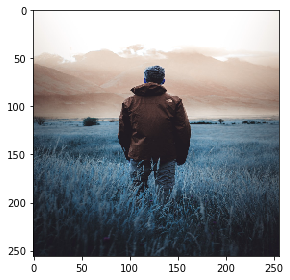

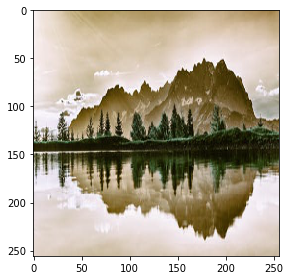

        y


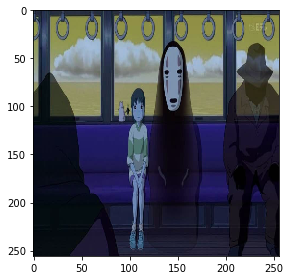

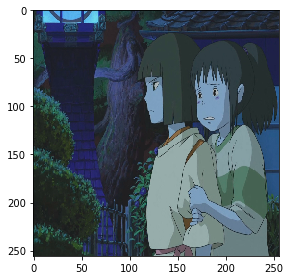

        ys


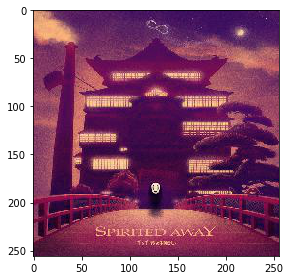

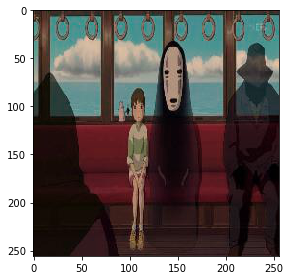

(2, 256, 256, 3) (2, 256, 256, 3) (2, 256, 256, 3)
current batch
        x


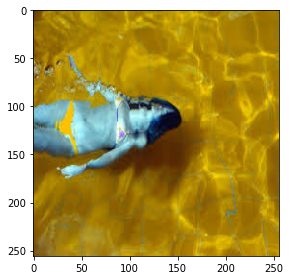

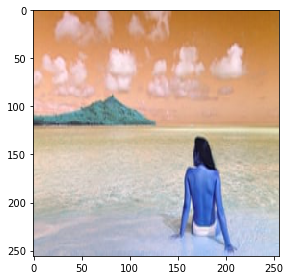

        y


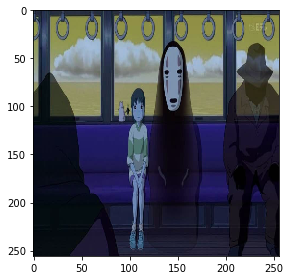

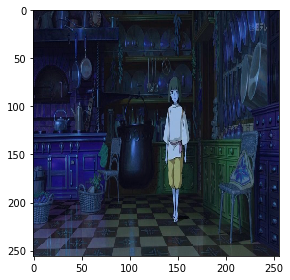

        ys


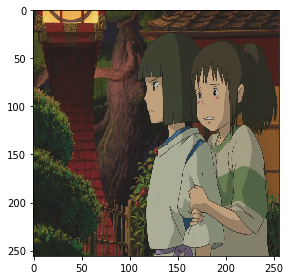

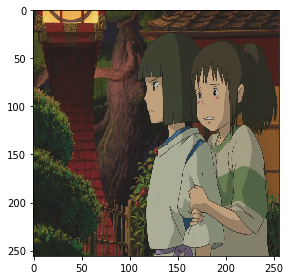

(2, 256, 256, 3) (2, 256, 256, 3) (2, 256, 256, 3)
current batch
        x


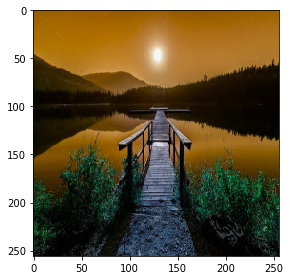

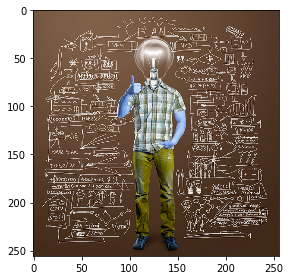

        y


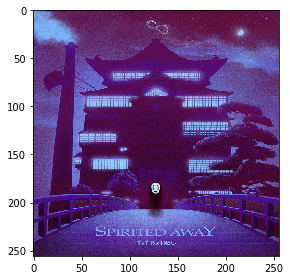

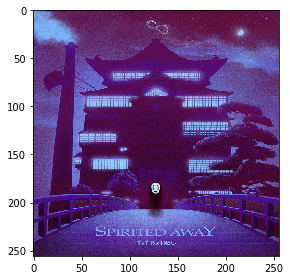

        ys


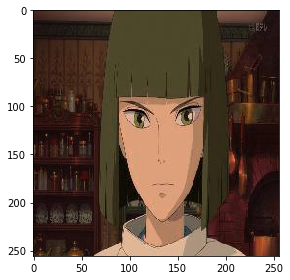

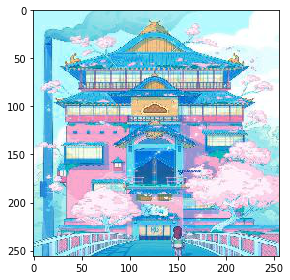

(2, 256, 256, 3) (2, 256, 256, 3) (2, 256, 256, 3)
current batch
        x


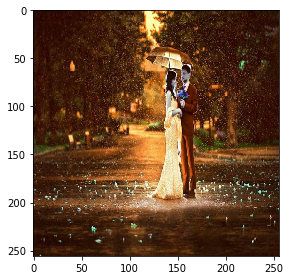

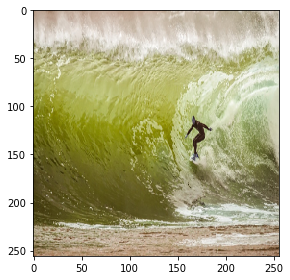

        y


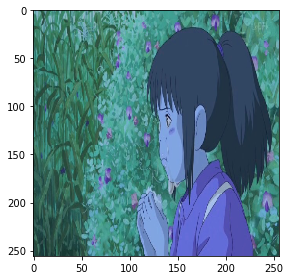

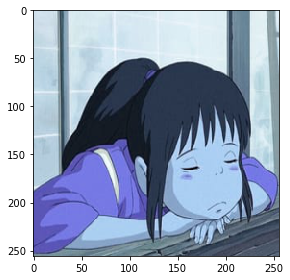

        ys


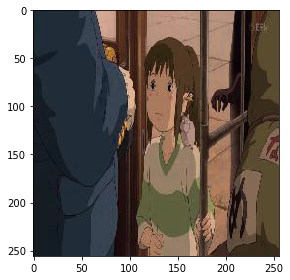

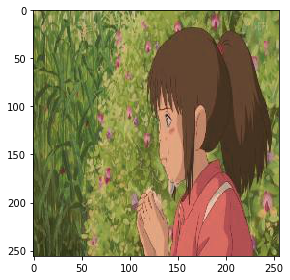

(2, 256, 256, 3) (2, 256, 256, 3) (2, 256, 256, 3)
current batch
        x


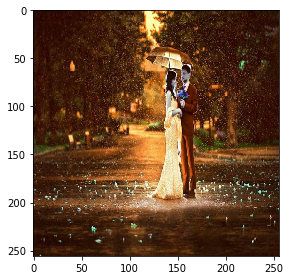

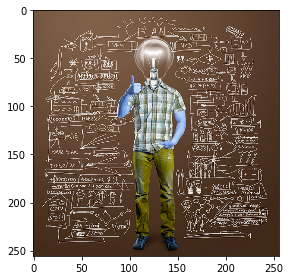

        y


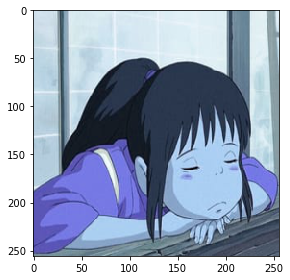

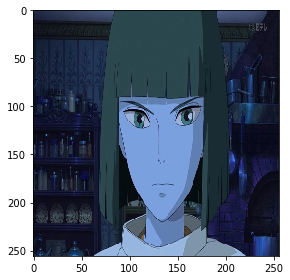

        ys


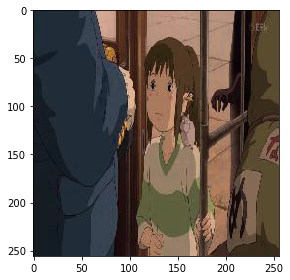

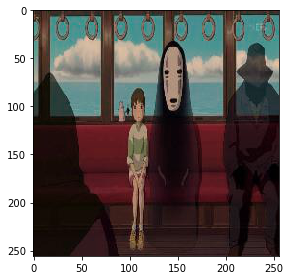

In [0]:



def get_images_from_tf_record(tf_record_path):
    filenames_queues = tf.train.string_input_producer([tf_record_path], 
                                                      num_epochs = config.NUM_EPOCHS)

    images = read_decode(filenames_queues)
    return images


def read_images_batch():
    
#     x_images = get_images_from_tf_record(config.X_TF_RECORD_PATH)
#     y_images = get_images_from_tf_record(config.Y_TF_RECORD_PATH)
#     ys_images = get_images_from_tf_record(config.YS_TF_RECORD_PATH)
    x_images = get_images_from_tf_record(config.X_TF_RECORD_PATH)
    y_images = get_images_from_tf_record(config.Y_TF_RECORD_PATH)
    ys_images = get_images_from_tf_record(config.YS_TF_RECORD_PATH)
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    with tf.Session() as session:
        session.run(init)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord = coord)

        for i in range(5):
            x, y, ys = session.run([x_images, y_images, ys_images])
            print(np.shape(x), np.shape(y), np.shape(ys))

            print('current batch')

            # We selected the batch size of two
            # So we should get two image pairs in each batch
            # Let's make sure it is random
            print('        x')
            io.imshow(x[0])
            io.show()

    #         io.imshow(anno[0, :, :, 0])
    #         io.show()

            io.imshow(x[1])
            io.show()
            
              

            # We selected the batch size of two
            # So we should get two image pairs in each batch
            # Let's make sure it is random
            print('        y')
            io.imshow(y[0])
            io.show()

    #         io.imshow(anno[0, :, :, 0])
    #         io.show()

            io.imshow(y[1])
            io.show()
            
              

            # We selected the batch size of two
            # So we should get two image pairs in each batch
            # Let's make sure it is random
            print('        ys')
            io.imshow(ys[0])
            io.show()

    #         io.imshow(anno[0, :, :, 0])
    #         io.show()

            io.imshow(ys[1])
            io.show()

    #         io.imshow(anno[1, :, :, 0])
    #         io.show()


        coord.request_stop()
        coord.join(threads)
        
read_images_batch()

In [0]:
def _parse_function(filename):

    image_string = tf.read_file(tf.convert_to_tensor(filename))
    image_decoded = tf.image.decode_jpeg(image_string, channels = 3)
#     preprocess = Preprocess_images()
#     image = preprocess.image_processing(tf.convert_to_tensor(image_decoded))
    return image_decoded

 


filenames = glob.glob(config.TRAIN_X_DATA_PATH + '*')

dataset = tf.data.Dataset.from_tensor_slices(filenames)
dataset = dataset.map(_parse_function)
dataset = dataset.shuffle(buffer_size = 10 * 1) 
dataset = dataset.repeat(3).batch(1)
iterator = dataset.make_one_shot_iterator()
# next_image_batch = iterator.get_next()

(1, 237, 500, 3)
(1, 237, 500, 3)


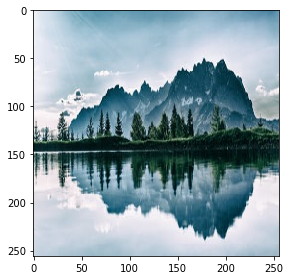

(1, 194, 259, 3)
(1, 194, 259, 3)


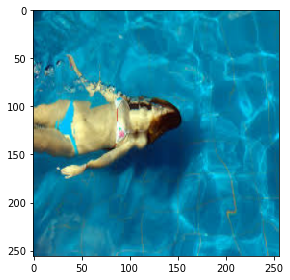

(1, 305, 200, 3)
(1, 305, 200, 3)


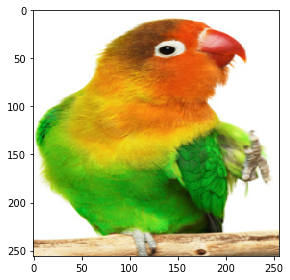

(1, 355, 500, 3)
(1, 355, 500, 3)


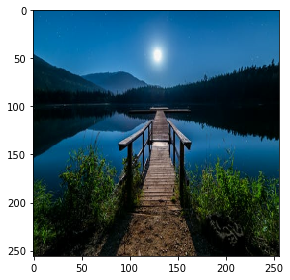

(1, 1250, 1000, 3)
(1, 1250, 1000, 3)


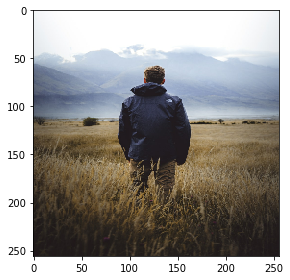

(1, 722, 690, 3)
(1, 722, 690, 3)


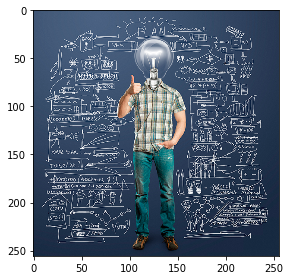

(1, 500, 800, 3)
(1, 500, 800, 3)


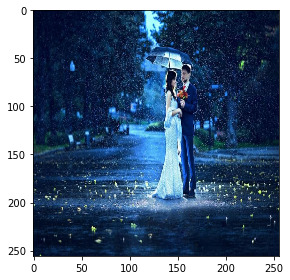

(1, 720, 1280, 3)
(1, 720, 1280, 3)


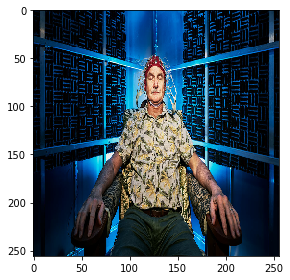

(1, 327, 600, 3)
(1, 327, 600, 3)


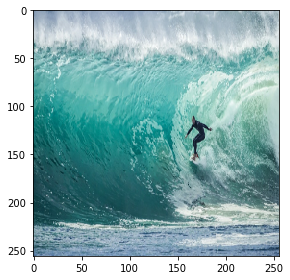

(1, 180, 300, 3)
(1, 180, 300, 3)


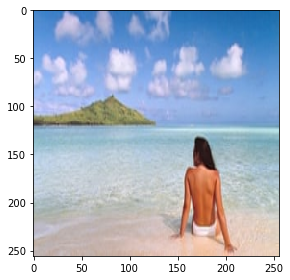

(1, 305, 200, 3)
(1, 305, 200, 3)


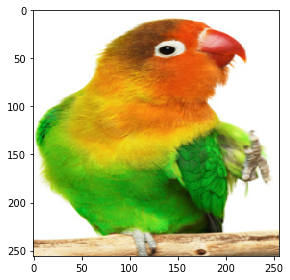

(1, 327, 600, 3)
(1, 327, 600, 3)


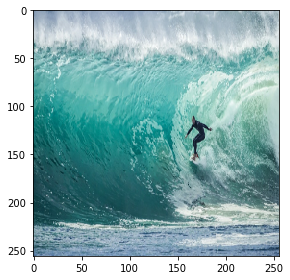

(1, 180, 300, 3)
(1, 180, 300, 3)


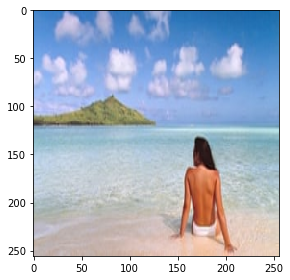

(1, 720, 1280, 3)
(1, 720, 1280, 3)


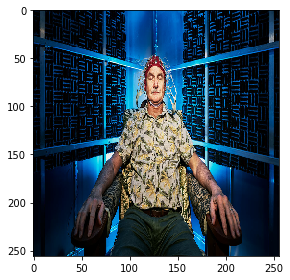

(1, 194, 259, 3)
(1, 194, 259, 3)


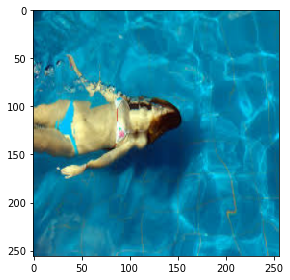

(1, 722, 690, 3)
(1, 722, 690, 3)


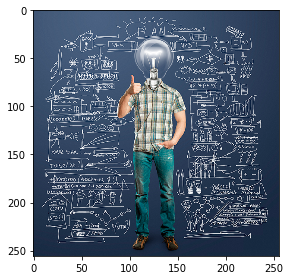

In [0]:
import skimage.io as io
with tf.Session() as session:
    for i in range(16):
        image_batch = session.run(iterator.get_next())
#         np_image = image_batch.eval()
        print(np.shape(image_batch))
#         io.imshow(image_batch[0])
#         io.show()
#         im
        print(np.shape(image_batch))
        io.imshow(cv2.resize(image_batch[0], (256, 256)))
        io.show()
#         im = tf.convert_to_tensor(image_batch)
#         print(im.get_shape().as_list())

In [0]:
l = np.arange(8).reshape(2, 4)
print(np.shape(l))
l = np.expand_dims(l, 0)
print(np.shape(l))

(2, 4)
(1, 2, 4)
